# Classification

A classification model is trained using preprocessed 2014's data to predict loan default rate.

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

In [149]:
df = pd.read_csv('Preprocessed_Data_2014.csv')

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [150]:
df.head()

,numtl30dpd,inqlast6mths,accnowdelinq,numactvrevtl,totalcutl,installment,revolutil,delinqamnt,mthssincercntil,term,...,mosinoldrevtlop,avgcurbal,secappmortacc,emptitle,mthssincelastdelinq,dti,emplength,totcurbal,issued,loanstatus
0,0.0,0.0,0.0,4.0,NaN,336.64,29%,0.0,NaN,60 months,...,244.0,29828.0,NaN,MANAGEMENT,NaN,12.03,10+ years,149140.0,Dec-2014,Fully Paid
1,0.0,2.0,0.0,9.0,NaN,321.08,31.6%,0.0,NaN,36 months,...,290.0,9536.0,NaN,Truck Driver Delivery Personel,42.0,14.92,8 years,162110.0,Dec-2014,Charged Off
2,0.0,0.0,0.0,5.0,NaN,319.08,100.9%,0.0,NaN,60 months,...,170.0,32727.0,NaN,Senior Sales Professional,17.0,8.31,10+ years,261815.0,Dec-2014,In Grace Period
3,0.0,0.0,0.0,4.0,NaN,516.36,76.2%,0.0,NaN,60 months,...,136.0,4232.0,NaN,Programming Analysis Supervisor,60.0,18.49,6 years,42315.0,Dec-2014,Fully Paid
4,0.0,1.0,0.0,4.0,NaN,260.20,91.9%,0.0,NaN,36 months,...,148.0,5857.0,NaN,Technical Specialist,NaN,34.81,< 1 year,64426.0,Dec-2014,Charged Off


## Feature Engineering

In [151]:
# separate the categorical and numerical data
all_null_feature=[]
num_feature=[]
ob_feature=[]
for col in df.columns:
    if df[col].isnull().sum()==df.shape[0]:
        all_null_feature.append(col)
    else:
        if df[col].dtype == 'object':
            ob_feature.append(col)
        else:
            num_feature.append(col)

In [152]:
all_null_feature

['totalcutl',
 'mthssincercntil',
 'totalbalil',
 'secappcollections12mthsexmed',
 'secappmthssincelastmajorderog',
 'allutil',
 'secappopenactil',
 'openactil',
 'maxbalbc',
 'openrv12m',
 'secappnumrevaccts',
 'secappinqlast6mths',
 'secappopenacc',
 'secappchargeoffwithin12mths',
 'verificationstatusjoint',
 'openil24m',
 'openil12m',
 'ilutil',
 'inqlast12m',
 'revolbaljoint',
 'inqfi',
 'openrv24m',
 'openacc6m',
 'secapprevolutil',
 'secappearliestcrline',
 'dtijoint',
 'memberid',
 'annualincjoint',
 'secappmortacc']

In [153]:
ob_feature

['revolutil',
 'term',
 'earliestcrline',
 'id',
 'disbursementmethod',
 'zipcode',
 'homeownership',
 'addrstate',
 'desc',
 'intrate',
 'subgrade',
 'applicationtype',
 'initialliststatus',
 'verificationstatus',
 'grade',
 'purpose',
 'emptitle',
 'emplength',
 'issued',
 'loanstatus']

In [154]:
num_feature

['numtl30dpd',
 'inqlast6mths',
 'accnowdelinq',
 'numactvrevtl',
 'installment',
 'delinqamnt',
 'openacc',
 'numbcsats',
 'bcopentobuy',
 'fundedamnt',
 'numacctsever120pd',
 'numtl120dpd2m',
 'totalbalexmort',
 'totalilhighcreditlimit',
 'accopenpast24mths',
 'mthssincelastrecord',
 'numsats',
 'mthssincelastmajorderog',
 'tothicredlim',
 'chargeoffwithin12mths',
 'mosinrcnttl',
 'collections12mthsexmed',
 'pcttlnvrdlq',
 'mthssincerecentbc',
 'numtl90gdpd24m',
 'mthssincerecentrevoldelinq',
 'mosinrcntrevtlop',
 'revolbal',
 'bcutil',
 'totalrevhilim',
 'mthssincerecentinq',
 'mosinoldilacct',
 'numtloppast12m',
 'percentbcgt75',
 'mthssincerecentbcdlq',
 'numrevtlbalgt0',
 'totalacc',
 'numoprevtl',
 'numactvbctl',
 'mortacc',
 'delinq2yrs',
 'totcollamt',
 'numrevaccts',
 'annualinc',
 'taxliens',
 'totalbclimit',
 'loanamnt',
 'numiltl',
 'pubrecbankruptcies',
 'numbctl',
 'pubrec',
 'mosinoldrevtlop',
 'avgcurbal',
 'mthssincelastdelinq',
 'dti',
 'totcurbal']

In [155]:
features = ob_feature + num_feature
len(features)

76

In [156]:
# remove applicationtype, disbursementmethod since it only has one value as 'individual'

features.remove('applicationtype')
features.remove('disbursementmethod')

In [157]:
# remove 'id', 'issued', 'loanstatus' from ob_feature, since they are indices, and train/test flags and labels

ob_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')

In [158]:
# remove desc' from ob_feature and features

ob_feature.remove('desc')

In [159]:
features = ob_feature + num_feature
len(features)

72

In [160]:
# select all features and delete the last two rows 

df = df[features + ['id', 'loanstatus', 'issued']][:-2]

In [161]:
df.shape

(235629, 75)

In [162]:
df['loanstatus'].value_counts()

Fully Paid            172687
Charged Off            39220
Current                22321
Late (31-120 days)       744
In Grace Period          506
Late (16-30 days)        150
Default                    1
Name: loanstatus, dtype: int64

In [163]:
df['term'].value_counts()

 36 months    162570
 60 months     73059
Name: term, dtype: int64

In [164]:
# only use loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' and term = '36 months'

df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off'")
df = df.query("term == ' 36 months'")
df

,revolutil,term,earliestcrline,disbursementmethod,zipcode,homeownership,addrstate,intrate,subgrade,applicationtype,...,numbctl,pubrec,mosinoldrevtlop,avgcurbal,mthssincelastdelinq,dti,totcurbal,id,loanstatus,issued
1,31.6%,36 months,Sep-1989,Cash,937xx,MORTGAGE,CA,6.99%,A3,Individual,...,18.0,0.0,290.0,9536.0,42.0,14.92,162110.0,NaN,Charged Off,Dec-2014
4,91.9%,36 months,Aug-2002,Cash,850xx,RENT,AZ,13.66%,C3,Individual,...,4.0,0.0,148.0,5857.0,NaN,34.81,64426.0,NaN,Charged Off,Dec-2014
5,59.4%,36 months,Nov-1992,Cash,077xx,RENT,NJ,13.66%,C3,Individual,...,16.0,0.0,265.0,3214.0,NaN,25.81,38566.0,NaN,Fully Paid,Dec-2014
6,46.4%,36 months,Jan-2001,Cash,144xx,MORTGAGE,NY,13.66%,C3,Individual,...,7.0,0.0,167.0,17456.0,46.0,23.63,122193.0,NaN,Fully Paid,Dec-2014
8,33.1%,36 months,Jan-1999,Cash,331xx,RENT,FL,17.86%,D5,Individual,...,6.0,0.0,122.0,1571.0,48.0,22.42,17281.0,NaN,Charged Off,Dec-2014
9,20.2%,36 months,May-2009,Cash,208xx,RENT,MD,11.44%,B4,Individual,...,4.0,0.0,67.0,1267.0,NaN,14.36,10133.0,NaN,Fully Paid,Dec-2014
10,98%,36 months,Jul-2003,Cash,483xx,RENT,MI,11.99%,B5,Individual,...,6.0,0.0,124.0,4745.0,NaN,8.44,23723.0,NaN,Charged Off,Dec-2014
11,94.3%,36 months,Oct-2001,Cash,554xx,MORTGAGE,MN,11.99%,B5,Individual,...,6.0,0.0,148.0,44136.0,55.0,13.77,397223.0,NaN,Fully Paid,Dec-2014
12,82.2%,36 months,Oct-1998,Cash,982xx,RENT,WA,14.31%,C4,Individual,...,9.0,0.0,194.0,39356.0,1.0,27.03,393558.0,NaN,Charged Off,Dec-2014
14,82.6%,36 months,Jul-1989,Cash,403xx,MORTGAGE,KY,10.49%,B3,Individual,...,9.0,0.0,305.0,40153.0,9.0,6.87,361379.0,NaN,Fully Paid,Dec-2014


In [165]:
# label target
df['loanstatus'] = df.loanstatus.map({'Charged Off': 1, 'Fully Paid': 0})

In [166]:
df

,revolutil,term,earliestcrline,disbursementmethod,zipcode,homeownership,addrstate,intrate,subgrade,applicationtype,...,numbctl,pubrec,mosinoldrevtlop,avgcurbal,mthssincelastdelinq,dti,totcurbal,id,loanstatus,issued
1,31.6%,36 months,Sep-1989,Cash,937xx,MORTGAGE,CA,6.99%,A3,Individual,...,18.0,0.0,290.0,9536.0,42.0,14.92,162110.0,NaN,1,Dec-2014
4,91.9%,36 months,Aug-2002,Cash,850xx,RENT,AZ,13.66%,C3,Individual,...,4.0,0.0,148.0,5857.0,NaN,34.81,64426.0,NaN,1,Dec-2014
5,59.4%,36 months,Nov-1992,Cash,077xx,RENT,NJ,13.66%,C3,Individual,...,16.0,0.0,265.0,3214.0,NaN,25.81,38566.0,NaN,0,Dec-2014
6,46.4%,36 months,Jan-2001,Cash,144xx,MORTGAGE,NY,13.66%,C3,Individual,...,7.0,0.0,167.0,17456.0,46.0,23.63,122193.0,NaN,0,Dec-2014
8,33.1%,36 months,Jan-1999,Cash,331xx,RENT,FL,17.86%,D5,Individual,...,6.0,0.0,122.0,1571.0,48.0,22.42,17281.0,NaN,1,Dec-2014
9,20.2%,36 months,May-2009,Cash,208xx,RENT,MD,11.44%,B4,Individual,...,4.0,0.0,67.0,1267.0,NaN,14.36,10133.0,NaN,0,Dec-2014
10,98%,36 months,Jul-2003,Cash,483xx,RENT,MI,11.99%,B5,Individual,...,6.0,0.0,124.0,4745.0,NaN,8.44,23723.0,NaN,1,Dec-2014
11,94.3%,36 months,Oct-2001,Cash,554xx,MORTGAGE,MN,11.99%,B5,Individual,...,6.0,0.0,148.0,44136.0,55.0,13.77,397223.0,NaN,0,Dec-2014
12,82.2%,36 months,Oct-1998,Cash,982xx,RENT,WA,14.31%,C4,Individual,...,9.0,0.0,194.0,39356.0,1.0,27.03,393558.0,NaN,1,Dec-2014
14,82.6%,36 months,Jul-1989,Cash,403xx,MORTGAGE,KY,10.49%,B3,Individual,...,9.0,0.0,305.0,40153.0,9.0,6.87,361379.0,NaN,0,Dec-2014


In [167]:
print(df.loanstatus.value_counts())
print(df.loanstatus.value_counts(normalize=True))

0    140235
1     22303
Name: loanstatus, dtype: int64
0    0.862783
1    0.137217
Name: loanstatus, dtype: float64


In [168]:
# out of time testing set and in-time training set: Oct-Dec as test
issued = list(df['issued'].unique())
issued

['Dec-2014',
 'Nov-2014',
 'Oct-2014',
 'Sep-2014',
 'Aug-2014',
 'Jul-2014',
 'Jun-2014',
 'May-2014',
 'Apr-2014',
 'Mar-2014',
 'Feb-2014',
 'Jan-2014']

In [169]:
df['train_flag'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df.train_flag.value_counts()

1    112550
0     49988
Name: train_flag, dtype: int64

In [170]:
df.earliestcrline[1].split('-')[1]

'1989'

In [171]:
# datetime to numeric feature

df.earliestcrline.unique()[:5]

array(['Sep-1989', 'Aug-2002', 'Nov-1992', 'Jan-2001', 'Jan-1999'],
      dtype=object)

In [172]:
# convert to number of months to Dec 2014

cl_month = df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year = df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [173]:
cl_month.unique()

array(['Sep', 'Aug', 'Nov', 'Jan', 'May', 'Jul', 'Oct', 'Jun', 'Dec',
       'Feb', 'Apr', 'Mar'], dtype=object)

In [174]:
cl_year.unique()

array([1989, 2002, 1992, 2001, 1999, 2009, 2003, 1998, 1996, 1995, 1993,
       2010, 2006, 2007, 2000, 2011, 2004, 1994, 1997, 1984, 1988, 2008,
       2005, 1987, 1991, 1986, 1973, 1985, 1982, 1974, 1979, 1976, 1983,
       1990, 1978, 1981, 1980, 1977, 1969, 1971, 1967, 1972, 1968, 1962,
       1975, 1965, 1966, 1963, 1970, 1964, 1958, 1955, 1959, 1961, 1960,
       1954, 1957, 1949, 1950, 1948, 1953, 1956])

In [175]:
dict_month = {
    'Jan': 11,
    'Feb': 10,
    'Mar': 9,
    'Apr': 8,
    'May': 7,
    'Jun': 6,
    'Jul': 5,
    'Aug': 4,
    'Sep': 3,
    'Oct': 2,
    'Nov': 1,
    'Dec': 0,
}

In [176]:
df['earliestcrline_month'] = df.earliestcrline.apply(lambda x: (2014 - int(x.split('-')[1]))*12 + dict_month[x.split('-')[0]])

In [177]:
df.earliestcrline_month[:5]

1    303
4    148
5    265
6    167
8    191
Name: earliestcrline_month, dtype: int64

In [178]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')

In [179]:
print(len(ob_feature), len(num_feature))

15 57


In [180]:
# convert emplength to numeric
print(df['emplength'].isnull().sum())
df['emplength'].unique()

9644


array(['8 years', '< 1 year', '10+ years', '2 years', '9 years',
       '7 years', '5 years', '3 years', '4 years', nan, '1 year',
       '6 years'], dtype=object)

In [181]:
df['emplength'].replace('n/a', np.nan, inplace=True)
df['emplength'].replace('< 1 year', 0, inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999, inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [182]:
df.emplength.value_counts()

 10     51133
 2      14665
 3      13105
 0      13054
 1      10568
 4       9668
-999     9644
 5       9147
 7       8943
 6       8205
 8       8130
 9       6276
Name: emplength, dtype: int64

In [183]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print(len(num_feature), len(ob_feature))

58 14


In [184]:
# intrate, revolutil to numeric feature

intrate = df.intrate.apply(lambda x: float(x.replace('%', '')))

In [185]:
df.intrate = intrate
df.intrate[:2]

1     6.99
4    13.66
Name: intrate, dtype: float64

In [186]:
df.revolutil[:3]

1    31.6%
4    91.9%
5    59.4%
Name: revolutil, dtype: object

In [187]:
revolutil = df.revolutil.apply(lambda x: str(x).replace('%', '')).astype(float)

In [188]:
df.revolutil= revolutil
df.revolutil[:2]

1    31.6
4    91.9
Name: revolutil, dtype: float64

In [189]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [190]:
print(len(ob_feature), len(num_feature))

12 60


In [191]:
dict_grade = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

In [192]:
df.grade = df.grade.map(dict_grade)

In [193]:
df.subgrade = df.subgrade.apply(lambda x: (dict_grade[x[0]] - 1)*5 + int(x[1]))

In [194]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [195]:
print(len(ob_feature), len(num_feature))

10 62


In [196]:
# high cardinality feature encoding

print(df.zipcode.nunique(), df.zipcode.unique()[:5])

854 ['937xx' '850xx' '077xx' '144xx' '331xx']


In [197]:
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [198]:
df.zipcode[:5]

1    937
4    850
5     77
6    144
8    331
Name: zipcode, dtype: int64

In [199]:
zipcode_freq = df.groupby('zipcode').size().reset_index()
zipcode_freq[:5]

,zipcode,0
0,8,1
1,10,229
2,11,66
3,12,69
4,13,41


In [200]:
zipcode_freq.columns = ['zipcode', 'zipcode_freq']

In [201]:
df = pd.merge(df, zipcode_freq, how='left', on='zipcode')

In [202]:
ob_feature.remove('zipcode')
num_feature.append('zipcode')
num_feature.append('zipcode_freq')
print(len(ob_feature), len(num_feature))

9 64


In [203]:
# emptitle-frequency encoding

emptitle_freq = df.groupby('emptitle').size().reset_index()
emptitle_freq.columns = ['emptitle', 'emptitle_freq']
df = pd.merge(df, emptitle_freq, how='left', on='emptitle')

In [204]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print(len(ob_feature), len(num_feature))

8 65


In [205]:
# Addr_state-frequency encoding

emptitle_freq = df.groupby('addrstate').size().reset_index()
emptitle_freq.columns = ['addrstate', 'addrstate_freq']
df = pd.merge(df, emptitle_freq, how='left', on='addrstate')

In [206]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')
print(len(ob_feature), len(num_feature))

7 66


In [207]:
# one-hot encoding

dummy_features = ['homeownership', 'verificationstatus', 'purpose', 'initialliststatus']
df_dummy = pd.get_dummies(df[dummy_features])
OHE_features = list(df_dummy.columns.values)

In [208]:
len(OHE_features)

22

In [209]:
df = pd.concat([df, df_dummy], axis=1)

In [210]:
df.shape

(162538, 102)

In [211]:
for feature in dummy_features:
    ob_feature.remove(feature)

In [212]:
len(ob_feature)

3

In [213]:
ob_feature

['term', 'disbursementmethod', 'applicationtype']

In [214]:
df['term'].describe()

count         162538
unique             1
top        36 months
freq          162538
Name: term, dtype: object

In [215]:
features_selected = num_feature + OHE_features

In [216]:
len(features_selected)

88

In [217]:
features_selected.sort()
features_selected

['accnowdelinq',
 'accopenpast24mths',
 'addrstate_freq',
 'annualinc',
 'avgcurbal',
 'bcopentobuy',
 'bcutil',
 'chargeoffwithin12mths',
 'collections12mthsexmed',
 'delinq2yrs',
 'delinqamnt',
 'dti',
 'earliestcrline_month',
 'emplength',
 'emptitle_freq',
 'fundedamnt',
 'grade',
 'homeownership_ANY',
 'homeownership_MORTGAGE',
 'homeownership_OWN',
 'homeownership_RENT',
 'initialliststatus_f',
 'initialliststatus_w',
 'inqlast6mths',
 'installment',
 'intrate',
 'loanamnt',
 'mortacc',
 'mosinoldilacct',
 'mosinoldrevtlop',
 'mosinrcntrevtlop',
 'mosinrcnttl',
 'mthssincelastdelinq',
 'mthssincelastmajorderog',
 'mthssincelastrecord',
 'mthssincerecentbc',
 'mthssincerecentbcdlq',
 'mthssincerecentinq',
 'mthssincerecentrevoldelinq',
 'numacctsever120pd',
 'numactvbctl',
 'numactvrevtl',
 'numbcsats',
 'numbctl',
 'numiltl',
 'numoprevtl',
 'numrevaccts',
 'numrevtlbalgt0',
 'numsats',
 'numtl120dpd2m',
 'numtl30dpd',
 'numtl90gdpd24m',
 'numtloppast12m',
 'openacc',
 'pcttlnvrd

In [218]:
# pick a data point as benchmark
benchmark = df[features_selected].iloc[1,:]
benchmark

accnowdelinq                              0.00
accopenpast24mths                         6.00
addrstate_freq                         3889.00
annualinc                             50000.00
avgcurbal                              5857.00
bcopentobuy                             332.00
bcutil                                   93.20
chargeoffwithin12mths                     0.00
collections12mthsexmed                    0.00
delinq2yrs                                0.00
delinqamnt                                0.00
dti                                      34.81
earliestcrline_month                    148.00
emplength                                 0.00
emptitle_freq                            17.00
fundedamnt                             7650.00
grade                                     3.00
homeownership_ANY                         0.00
homeownership_MORTGAGE                    0.00
homeownership_OWN                         0.00
homeownership_RENT                        1.00
initiallistst

In [219]:
with open('feature_new.pkl', 'wb') as outfile:
    pickle.dump(benchmark.to_frame().transpose(), outfile)

In [243]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [221]:
df_train = df.query('train_flag == 1')
df_test = df.query('train_flag == 0')

In [222]:
print(df_train.shape, df_test.shape)

(112550, 102) (49988, 102)


In [223]:
df_train[features_selected].shape

(112550, 88)

## Modeling Training

In [224]:
# split training and test data
X_train, X_valid, y_train, y_valid = train_test_split(df_train[features_selected], df_train.loanstatus,
                                                     test_size = 0.3, random_state=2014, stratify=df_train.loanstatus)

In [225]:
X_test, y_test = df_test[features_selected], df_test.loanstatus

In [227]:
dtrain = xgb.DMatrix(X_train, y_train, missing=np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing=np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing=np.NAN)

In [228]:
params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eta': 0.01,
    'max_depth': 6,
#     'subsample': 0.632,
#     'colsample_bytree': 0.7,
    'seed': 1234,
    'eval_metric': 'auc',
    'min_child_weight': 5
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

[0]	train-auc:0.677717	valid-auc:0.65641
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.681082	valid-auc:0.657968
[2]	train-auc:0.682417	valid-auc:0.658943
[3]	train-auc:0.683277	valid-auc:0.658584
[4]	train-auc:0.683451	valid-auc:0.659251
[5]	train-auc:0.683851	valid-auc:0.659367
[6]	train-auc:0.684103	valid-auc:0.659626
[7]	train-auc:0.685345	valid-auc:0.660957
[8]	train-auc:0.68551	valid-auc:0.660512
[9]	train-auc:0.686112	valid-auc:0.661696
[10]	train-auc:0.687624	valid-auc:0.662305
[11]	train-auc:0.689871	valid-auc:0.663797
[12]	train-auc:0.689974	valid-auc:0.664041
[13]	train-auc:0.691184	valid-auc:0.664592
[14]	train-auc:0.691551	valid-auc:0.66463
[15]	train-auc:0.692869	valid-auc:0.665464
[16]	train-auc:0.693335	valid-auc:0.665718
[17]	train-auc:0.6938	valid-auc:0.665987
[18]	train-auc:0.694342	valid-auc:0.666107
[19]	train-auc:0.694937	valid-auc:0.666456
[20]	train-a

[187]	train-auc:0.721413	valid-auc:0.678841
[188]	train-auc:0.721524	valid-auc:0.678849
[189]	train-auc:0.721632	valid-auc:0.678908
[190]	train-auc:0.721745	valid-auc:0.678946
[191]	train-auc:0.721901	valid-auc:0.678981
[192]	train-auc:0.722019	valid-auc:0.679036
[193]	train-auc:0.722134	valid-auc:0.679095
[194]	train-auc:0.722252	valid-auc:0.679155
[195]	train-auc:0.722364	valid-auc:0.679171
[196]	train-auc:0.722453	valid-auc:0.679189
[197]	train-auc:0.722566	valid-auc:0.679264
[198]	train-auc:0.7227	valid-auc:0.679277
[199]	train-auc:0.722815	valid-auc:0.679352
[200]	train-auc:0.722909	valid-auc:0.679402
[201]	train-auc:0.723029	valid-auc:0.679438
[202]	train-auc:0.723143	valid-auc:0.679517
[203]	train-auc:0.723267	valid-auc:0.679562
[204]	train-auc:0.723398	valid-auc:0.679581
[205]	train-auc:0.723484	valid-auc:0.679591
[206]	train-auc:0.723591	valid-auc:0.679652
[207]	train-auc:0.723702	valid-auc:0.679703
[208]	train-auc:0.723834	valid-auc:0.679748
[209]	train-auc:0.724012	valid-auc

[374]	train-auc:0.745455	valid-auc:0.684305
[375]	train-auc:0.745511	valid-auc:0.68429
[376]	train-auc:0.745668	valid-auc:0.684309
[377]	train-auc:0.745737	valid-auc:0.684339
[378]	train-auc:0.745926	valid-auc:0.684369
[379]	train-auc:0.746108	valid-auc:0.684405
[380]	train-auc:0.746324	valid-auc:0.684428
[381]	train-auc:0.746429	valid-auc:0.684455
[382]	train-auc:0.746569	valid-auc:0.684508
[383]	train-auc:0.74675	valid-auc:0.684525
[384]	train-auc:0.746864	valid-auc:0.68455
[385]	train-auc:0.747048	valid-auc:0.684587
[386]	train-auc:0.747223	valid-auc:0.684607
[387]	train-auc:0.747352	valid-auc:0.684669
[388]	train-auc:0.747535	valid-auc:0.684701
[389]	train-auc:0.74769	valid-auc:0.684761
[390]	train-auc:0.747838	valid-auc:0.684793
[391]	train-auc:0.747927	valid-auc:0.684829
[392]	train-auc:0.748097	valid-auc:0.684828
[393]	train-auc:0.748161	valid-auc:0.684827
[394]	train-auc:0.748372	valid-auc:0.684872
[395]	train-auc:0.748522	valid-auc:0.684907
[396]	train-auc:0.748612	valid-auc:0

[562]	train-auc:0.768014	valid-auc:0.686977
[563]	train-auc:0.768106	valid-auc:0.686984
[564]	train-auc:0.768184	valid-auc:0.686989
[565]	train-auc:0.768289	valid-auc:0.687008
[566]	train-auc:0.768399	valid-auc:0.686984
[567]	train-auc:0.768491	valid-auc:0.686984
[568]	train-auc:0.768566	valid-auc:0.686997
[569]	train-auc:0.768651	valid-auc:0.687025
[570]	train-auc:0.768769	valid-auc:0.687041
[571]	train-auc:0.768868	valid-auc:0.687025
[572]	train-auc:0.768953	valid-auc:0.687032
[573]	train-auc:0.769052	valid-auc:0.687043
[574]	train-auc:0.769162	valid-auc:0.687062
[575]	train-auc:0.769242	valid-auc:0.687068
[576]	train-auc:0.769295	valid-auc:0.687093
[577]	train-auc:0.769431	valid-auc:0.687123
[578]	train-auc:0.769489	valid-auc:0.687121
[579]	train-auc:0.769569	valid-auc:0.687118
[580]	train-auc:0.769695	valid-auc:0.687119
[581]	train-auc:0.769802	valid-auc:0.68713
[582]	train-auc:0.769852	valid-auc:0.687145
[583]	train-auc:0.769965	valid-auc:0.687121
[584]	train-auc:0.770037	valid-au

[749]	train-auc:0.783514	valid-auc:0.687958
[750]	train-auc:0.783545	valid-auc:0.687969
[751]	train-auc:0.783648	valid-auc:0.687968
[752]	train-auc:0.783721	valid-auc:0.687977
[753]	train-auc:0.783764	valid-auc:0.68798
[754]	train-auc:0.783801	valid-auc:0.687973
[755]	train-auc:0.783851	valid-auc:0.687953
[756]	train-auc:0.783896	valid-auc:0.687939
[757]	train-auc:0.783982	valid-auc:0.687924
[758]	train-auc:0.784079	valid-auc:0.687928
[759]	train-auc:0.784224	valid-auc:0.687931
[760]	train-auc:0.784276	valid-auc:0.687923
[761]	train-auc:0.78431	valid-auc:0.687911
[762]	train-auc:0.784398	valid-auc:0.687906
[763]	train-auc:0.784452	valid-auc:0.687907
[764]	train-auc:0.784521	valid-auc:0.687897
[765]	train-auc:0.784612	valid-auc:0.687895
[766]	train-auc:0.784664	valid-auc:0.687885
[767]	train-auc:0.784719	valid-auc:0.687886
[768]	train-auc:0.784756	valid-auc:0.687886
[769]	train-auc:0.784848	valid-auc:0.687878
[770]	train-auc:0.78493	valid-auc:0.687857
[771]	train-auc:0.785004	valid-auc:

## Model Evaluation

In [229]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl

def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test):
    probas = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print('auc_valid', roc_auc)
    print('auc_train', roc_auc_1)
    print('auc_test', roc_auc_2)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label='auc_valid = {:.5}'.format(roc_auc), color='r')
    plt.plot(fpr_1, tpr_1, label='auc_train = {:.5}'.format(roc_auc_1), color='g')
    plt.plot(fpr_2, tpr_2, label='auc_test = {:.5}'.format(roc_auc_2), color='b')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC')
    plt.legend(loc='lower right')
    plt.show()

auc_valid 0.6879804214533137
auc_train 0.7837639192829975
auc_test 0.6957570804551585


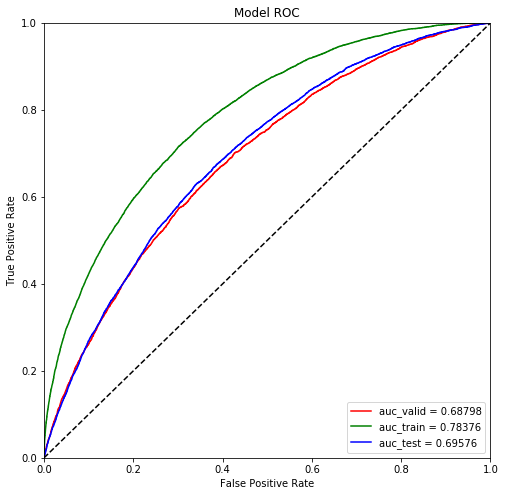

In [230]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

In [231]:
y_pred = gbm.predict(dtest)

In [232]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.6174121 0.0071251923 0.1359033


In [233]:
feature_importance = gbm.get_fscore()

In [234]:
df_feature_importance = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'fscore'])
df_feature_importance['fscore'] = df_feature_importance['fscore'] / df_feature_importance['fscore'].sum()

In [235]:
df_feature_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_feature_importance

,feature,fscore
7,dti,0.050564
2,annualinc,0.044043
15,installment,0.040435
6,mosinoldilacct,0.039874
17,mosinoldrevtlop,0.038725
1,intrate,0.032605
5,emptitle_freq,0.031108
12,accopenpast24mths,0.030814
23,mthssincerecentbc,0.027848
11,tothicredlim,0.027714


Text(0.5,0,'Importance')

<Figure size 2304x2304 with 0 Axes>

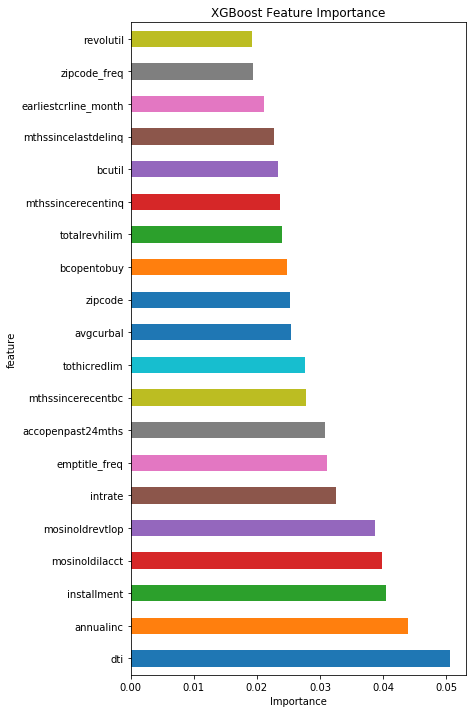

In [236]:
plt.figure(figsize=(32, 32))
df_feature_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 12))
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
# plt.savefig('xgb_feature_importance.png')

In [237]:
grade_importance = df_feature_importance.query("feature=='grade'")
grade_importance

,feature,fscore
0,grade,0.004089


In [238]:
grade_importance = df_feature_importance.query("feature=='subgrade'")
grade_importance

,feature,fscore
14,subgrade,0.014298


In [239]:
grade_importance = df_feature_importance.query("feature=='intrate'")
grade_importance

,feature,fscore
1,intrate,0.032605


In [240]:
grade_importance = df_feature_importance.query("feature=='loanamnt'")
grade_importance

,feature,fscore


Text(0.5,0,'Importance')

<Figure size 2304x2304 with 0 Axes>

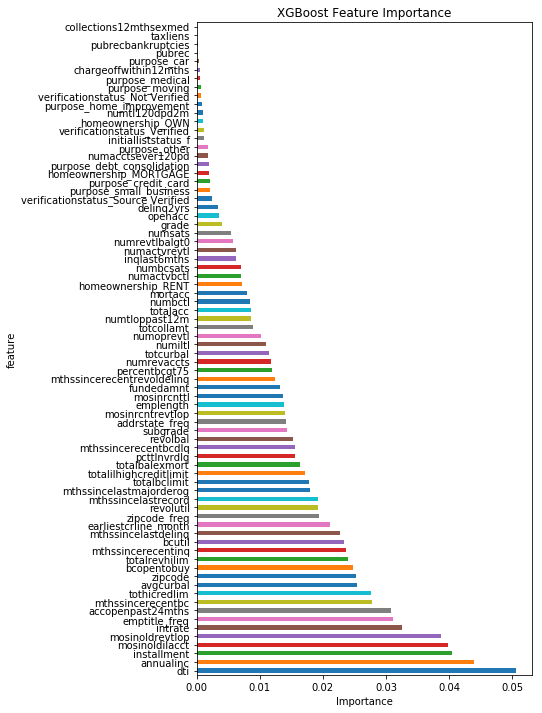

In [241]:
plt.figure(figsize=(32, 32))
df_feature_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 12))
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')

In [242]:
with open('model_new.pkl', 'wb') as outfile:
    pickle.dump(gbm, outfile)

In [96]:
feature_old = pd.read_pickle('./Demo Flask/iFlask/fintech/model/feature.pkl')
list(feature_old.columns)

['loan_amnt',
 'funded_amnt',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_s

In [259]:
feature_old

,loan_amnt,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_May-2014,last_credit_pull_d_May-2015,last_credit_pull_d_May-2016,last_credit_pull_d_Nov-2014,last_credit_pull_d_Nov-2015,last_credit_pull_d_Oct-2014,last_credit_pull_d_Oct-2015,last_credit_pull_d_Sep-2014,last_credit_pull_d_Sep-2015,application_type_INDIVIDUAL
28007,10000,8000.0,0.5,182.49,1,4,4,75000.0,18.16,0.0,...,0,0,0,0,0,0,0,0,0,1


In [248]:
feature_new = pd.read_pickle('./Demo Flask/iFlask/fintech/model/feature_new.pkl')
list(feature_new.columns)

['accnowdelinq',
 'accopenpast24mths',
 'addrstate_freq',
 'annualinc',
 'avgcurbal',
 'bcopentobuy',
 'bcutil',
 'chargeoffwithin12mths',
 'collections12mthsexmed',
 'delinq2yrs',
 'delinqamnt',
 'dti',
 'earliestcrline_month',
 'emplength',
 'emptitle_freq',
 'fundedamnt',
 'grade',
 'homeownership_ANY',
 'homeownership_MORTGAGE',
 'homeownership_OWN',
 'homeownership_RENT',
 'initialliststatus_f',
 'initialliststatus_w',
 'inqlast6mths',
 'installment',
 'intrate',
 'loanamnt',
 'mortacc',
 'mosinoldilacct',
 'mosinoldrevtlop',
 'mosinrcntrevtlop',
 'mosinrcnttl',
 'mthssincelastdelinq',
 'mthssincelastmajorderog',
 'mthssincelastrecord',
 'mthssincerecentbc',
 'mthssincerecentbcdlq',
 'mthssincerecentinq',
 'mthssincerecentrevoldelinq',
 'numacctsever120pd',
 'numactvbctl',
 'numactvrevtl',
 'numbcsats',
 'numbctl',
 'numiltl',
 'numoprevtl',
 'numrevaccts',
 'numrevtlbalgt0',
 'numsats',
 'numtl120dpd2m',
 'numtl30dpd',
 'numtl90gdpd24m',
 'numtloppast12m',
 'openacc',
 'pcttlnvrd

In [257]:
feature_new

,accnowdelinq,accopenpast24mths,addrstate_freq,annualinc,avgcurbal,bcopentobuy,bcutil,chargeoffwithin12mths,collections12mthsexmed,delinq2yrs,...,totalilhighcreditlimit,totalrevhilim,totcollamt,totcurbal,tothicredlim,verificationstatus_Not Verified,verificationstatus_Source Verified,verificationstatus_Verified,zipcode,zipcode_freq
1,0.0,6.0,3889.0,50000.0,5857.0,332.0,93.2,0.0,0.0,0.0,...,64031.0,18300.0,0.0,64426.0,82331.0,0.0,1.0,0.0,850.0,735.0


In [101]:
list(set(feature_old) & set(feature_new))

['purpose_debt_consolidation',
 'purpose_other',
 'purpose_home_improvement',
 'purpose_wedding',
 'installment',
 'dti',
 'purpose_moving',
 'purpose_vacation',
 'purpose_car',
 'purpose_major_purchase',
 'grade',
 'purpose_credit_card',
 'purpose_small_business',
 'purpose_medical',
 'purpose_house',
 'purpose_renewable_energy']

In [12]:
# save trained model for further use
pd.read_pickle('./Demo Flask/iFlask/fintech/model/model.pkl')